In [ ]:
# thoughts -- frame stacking [ future frame prediction ]
# conv-lstm vs fc-lstm
# multiple agents
# loss function weights @ value, policy [ actions & action params]
# fix end of trajectory states [ not being updated ] -- roll over last trajectory end to new ?
# multi step

In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
import time
import os.path

# required 
from absl import flags
FLAGS = flags.FLAGS
FLAGS(['--'])

# note this import must happen after flag initialization
from pysc2.env import sc2_env
from pysc2.lib import actions
from pysc2.lib import features

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
envParams = { 'screenResX': 64,
             'screenResY': 64, 
             'screenResX_minimap': 32,
             'screenResY_minimap': 32,
             'visualizeFlag': True
            }

env_args = dict(
        map_name='DefeatRoaches',
        step_mul=1,
        game_steps_per_episode=0, # no limit
        screen_size_px = ( envParams['screenResX'], envParams['screenResX']), 
        minimap_size_px = ( envParams['screenResX_minimap'], envParams['screenResY_minimap']),
        visualize = True,
        score_index = None
)

In [8]:
env = sc2_env.SC2Env(**env_args) # ** syntax implies variable number named arguments
obs = env.reset()

# Raw Observation  [ contains entire state ]

In [9]:
!nvidia-smi

Thu Mar 15 10:51:27 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P8    28W / 149W |      1MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Screen layers

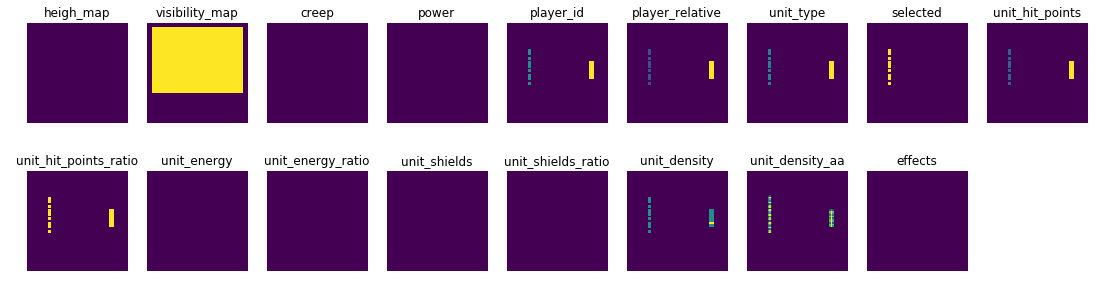

In [10]:
numScreenLayers = obs[0].observation['screen'].shape[0] # 17

plt.figure(figsize=(19,5))
titles = ['heigh_map', 'visibility_map', 'creep', 'power', 'player_id', 
          'player_relative', 'unit_type', 'selected', 
          'unit_hit_points', 'unit_hit_points_ratio', 
          'unit_energy', 'unit_energy_ratio', 
          'unit_shields', 'unit_shields_ratio', 
          'unit_density', 'unit_density_aa', 'effects']
[ [plt.subplot(2, 9, iScreenLayer+1), plt.imshow( obs[0].observation['screen'][iScreenLayer], aspect='equal'), 
       plt.title(titles[iScreenLayer]), plt.axis('off')] 
 for iScreenLayer in range(numScreenLayers) ]

# playerID, unit_type, selected, unit_hit_points, unit_hit_points_ratio
plt.show()

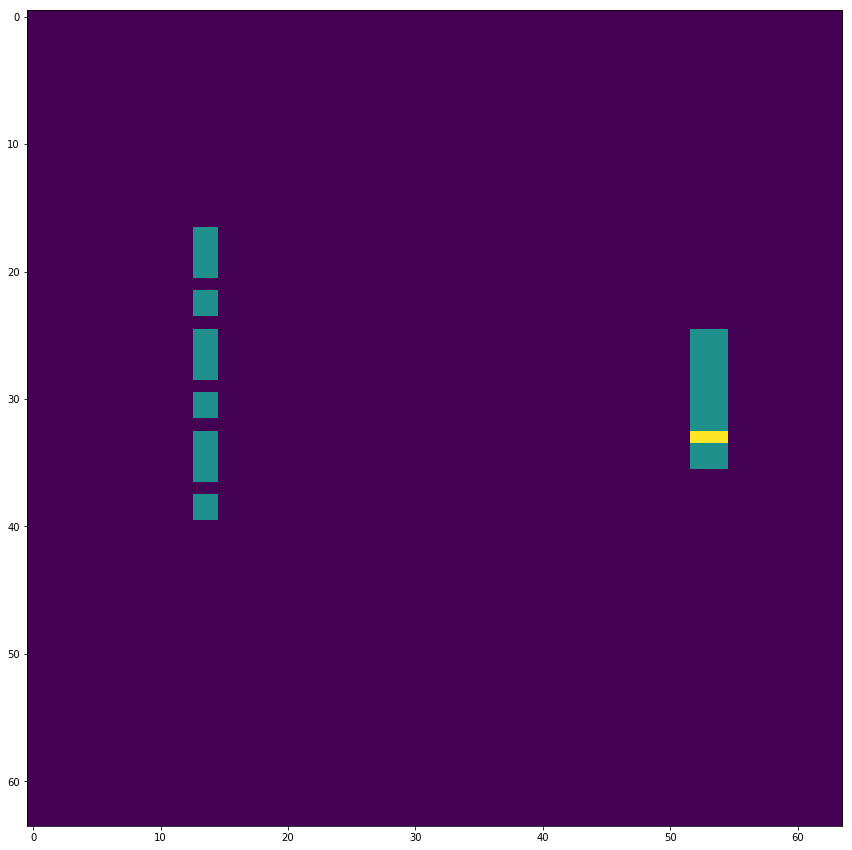

In [11]:
plt.figure(figsize=(15,15))
plt.imshow( obs[0].observation['screen'][14])
plt.show()

# Mini-map layers

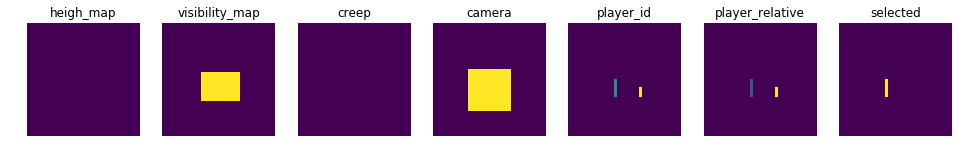

In [12]:
numMinimapLayers = obs[0].observation['minimap'].shape[0]
plt.figure(figsize=(19,10))
titles = ['heigh_map', 'visibility_map', 'creep', 'camera', 'player_id', 'player_relative', 'selected']
[ [plt.subplot(1, 8, iMinimapLayer+1), plt.imshow( obs[0].observation['minimap'][iMinimapLayer], aspect='equal'), 
       plt.title(titles[iMinimapLayer]), plt.axis('off')] 
 for iMinimapLayer in range(numMinimapLayers) ]

plt.show()

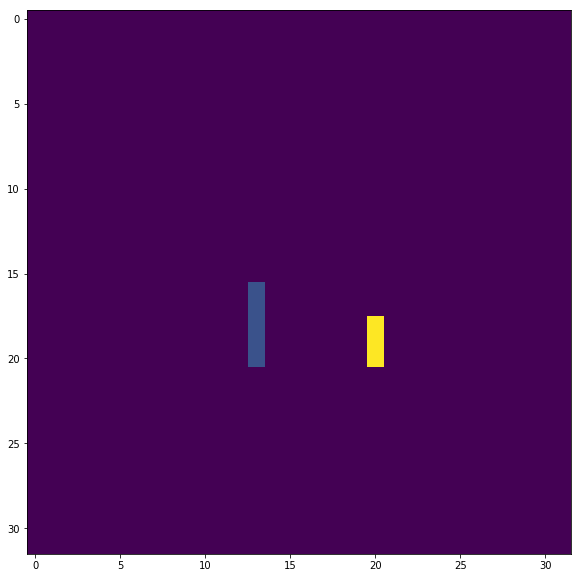

In [13]:
plt.figure(figsize=(10,10))
plt.imshow( obs[0].observation['minimap'][5])
plt.show()

# Environment Parameters

In [14]:
envParams = { 'screenResX': 64,
             'screenResY': 64, 
             'screenResX_minimap': 32,
             'screenResY_minimap': 32,
             'visualizeFlag': True,
             'simultaneousEnvironments': 1,
             'screenChannelsToKeep': [ 4, 5, 6, 7, 8, 9 ], # player_ID, player_relative, unit_type, selected, unit_hit_points, unit_hit_points_ratio
             'screenChannelsRetained': 6,
             
             #'allowedActionIDs': [ 0, 3, 7, 331, 12, 274], # noOp, select_rect, select_army, move_scren, attack_screen, hold_position
             #'allowedActionIDRequiresModifier': [ 0, 1, 1, 1, 1, 1 ],            
             #'allowedActionIDRequiresLocation': [ 0, 2, 0, 1, 1, 0 ],            
             #'prunedActionSpaceSize': 6,

             
             'allowedActionIDs': [ 3, 12 ], # select_rect, attack_screen
             'allowedActionIDRequiresModifier': [ 1, 1 ],            
             'allowedActionIDRequiresLocation': [ 2, 1 ],       

             #'allowedActionIDs': [ 7, 12 ], # select_army, attack_screen
             #'allowedActionIDRequiresModifier': [ 1, 1 ],            
             #'allowedActionIDRequiresLocation': [ 0, 1 ],       

             'prunedActionSpaceSize': 2,
             'actionArgumentSize': 4, 
             
             'nonVisualInputLength': 13,
             'nTrajectorySteps': 35,
             'futureDiscountRate': 1,
             'stepTypeFirst': 0,
             'stepTypeMid': 1,
             'stepTypeLast': 2,
            }

# sanity check environment parameter definition
assert ( envParams['prunedActionSpaceSize'] == len(envParams['allowedActionIDs']) \
            == len(envParams['allowedActionIDRequiresModifier']) \
            == len(envParams['allowedActionIDRequiresLocation']) )
assert ( envParams['screenChannelsRetained'] == len(envParams['screenChannelsToKeep'] ) )

# Model Parameters

In [15]:
from keras.layers import Input, Flatten, Dense, Dropout, Conv2D, Concatenate, concatenate, LSTM, LeakyReLU, TimeDistributed, CuDNNLSTM
from keras.models import Model


modelParams = { 'firstFCNeurons': 512, #8129,
                'secondFCNeurons': 2148,# 4096, 
                'lstmNeurons': 256, 
              }

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Model Definition

In [16]:
# TODO: CuDNNLSTM
# batch dimension do not need to be specified except at predict/train time

def build_LSTM_agent ( sequenceSteps = 1 ):

    # screen/visual features
    inputLayerScreenFeaturesSingleStep = Input( shape = ( sequenceSteps, 
                                                         envParams['screenChannelsRetained'],
                                                         envParams['screenResX'], 
                                                         envParams['screenResY'] ), 
                                               dtype=np.float32 )

    lstmStateH = Input( shape=( modelParams['lstmNeurons'], ) )
    lstmStateC = Input( shape=( modelParams['lstmNeurons'], ) )    
    
    '''
    # non-visual features (e.g., supply, current reward, cumulative score )
    auxilaryNonVisualInput = Input ( shape = (
        sequenceSteps,
        envParams['nonVisualInputLength'],) , dtype=np.float32)
    '''

    # conv2D input_shape with channels_first order expects input with shape ( samples, channels, rows, cols )
    firstConv = TimeDistributed ( 
                    Conv2D ( filters = 16, kernel_size = 8,
                         activation = 'relu', #LeakyReLU(alpha=0.3), #'relu', 
                         padding = 'same',
                         data_format = 'channels_first',
                         dilation_rate = 1, strides = 1 ) ) ( inputLayerScreenFeaturesSingleStep )

    # input_shape = ( envParams['simultaneousEnvironments'], envParams['screenChannelsRetained'], envParams['screenResX'], envParams['screenResY'] )
    secondConv = TimeDistributed ( 
                    Conv2D ( filters = 32, kernel_size = 4,
                         activation = 'relu', #LeakyReLU(alpha=0.3),
                         padding = 'same',
                         data_format = 'channels_first',
                         dilation_rate = 1, strides = 1)
                ) ( firstConv )

    # screen selection coordinates
    firstCoordinateConv = TimeDistributed ( 
                        Conv2D(1, 3, activation = 'linear', 
                               padding = 'same', 
                               data_format = 'channels_first')
                    ) (secondConv)
    
    secondCoordinateConv = TimeDistributed ( 
                        Conv2D(1, 3, activation = 'linear', 
                               padding = 'same', 
                               data_format = 'channels_first')
                    ) (secondConv)
        
    # flatten conv output to flat vector 
    flattenedConvOutput = TimeDistributed(Flatten()) (secondConv)

    # combine visual and non-visual features
    # screenAndAuxiliary = concatenate([auxilaryNonVisualInput, flattenedConvOutput], axis = 1)

    # first dense layer
    firstFC = TimeDistributed ( Dense ( modelParams['firstFCNeurons'], activation = 'linear' )) ( flattenedConvOutput )

    # final dense layer
    finalLayer, internalState1, internalState2 = \
                                  CuDNNLSTM ( modelParams['lstmNeurons'], 
                                        return_state = True, 
                                        return_sequences=True ) \
        ( firstFC, initial_state = [lstmStateH, lstmStateC] )

    # outputs
    value = TimeDistributed( Dense ( 1, activation = 'linear' ) ) ( finalLayer )

    actionID = TimeDistributed( Dense ( envParams['prunedActionSpaceSize'], activation = 'softmax' ) ) ( finalLayer )

    # combine visual and non-visual features -- concatenation necessary since loss function is applied to all outputs otherwise causing a dimensionality mismatch
    #finalLayerConcat = TimeDistributed( Concatenate(axis = 2)) ( value, actionID, actionPositionArgX1, actionPositionArgY1, actionPositionArgX2, actionPositionArgY2 ) )
    finalLayerConcat = concatenate([ value, actionID ], axis=2 )
    agentModel = Model ( inputs = [ inputLayerScreenFeaturesSingleStep, lstmStateH, lstmStateC ],
                        outputs = [ finalLayerConcat, internalState1, internalState2, 
                                   firstCoordinateConv, secondCoordinateConv ] )
    return agentModel

In [17]:
# TODO: CuDNNLSTM
# batch dimension do not need to be specified except at predict/train time

def build_LSTM_agent_trajectory ( sequenceSteps = 1 ):

    # screen/visual features
    inputLayerScreenFeaturesSingleStep = Input( shape = ( sequenceSteps, 
                                                         envParams['screenChannelsRetained'],
                                                         envParams['screenResX'], 
                                                         envParams['screenResY'] ), 
                                               dtype=np.float32 )

    lstmStateH = Input( shape=( modelParams['lstmNeurons'], ) )
    lstmStateC = Input( shape=( modelParams['lstmNeurons'], ) )    
    
    '''
    # non-visual features (e.g., supply, current reward, cumulative score )
    auxilaryNonVisualInput = Input ( shape = (
        sequenceSteps,
        envParams['nonVisualInputLength'],) , dtype=np.float32)
    '''

    # conv2D input_shape with channels_first order expects input with shape ( samples, channels, rows, cols )
    firstConv = TimeDistributed ( 
                    Conv2D ( filters = 16, kernel_size = 8,
                         activation = 'relu', #LeakyReLU(alpha=0.3), #'relu', 
                         padding = 'same',
                         data_format = 'channels_first',
                         dilation_rate = 1, strides = 1 ) ) ( inputLayerScreenFeaturesSingleStep )

    # input_shape = ( envParams['simultaneousEnvironments'], envParams['screenChannelsRetained'], envParams['screenResX'], envParams['screenResY'] )
    secondConv = TimeDistributed ( 
                    Conv2D ( filters = 32, kernel_size = 4,
                         activation = 'relu', #LeakyReLU(alpha=0.3),
                         padding = 'same',
                         data_format = 'channels_first',
                         dilation_rate = 1, strides = 1 )
                ) ( firstConv )

    
    # screen selection coordinates
    firstCoordinateConv = TimeDistributed ( 
                        Conv2D(1, 3, activation = 'linear', 
                               padding = 'same', 
                               data_format = 'channels_first')
                    ) (secondConv)
    
    secondCoordinateConv = TimeDistributed ( 
                        Conv2D(1, 3, activation = 'linear', 
                               padding = 'same', 
                               data_format = 'channels_first')
                    ) (secondConv)
    
    
    # flatten conv output to flat vector 
    flattenedConvOutput = TimeDistributed(Flatten()) (secondConv)

    # combine visual and non-visual features
    # screenAndAuxiliary = concatenate([auxilaryNonVisualInput, flattenedConvOutput], axis = 1)

    # first dense layer
    firstFC = TimeDistributed ( Dense ( modelParams['firstFCNeurons'], activation = 'linear' )) ( flattenedConvOutput )

    # final dense layer
    finalLayer = CuDNNLSTM ( modelParams['lstmNeurons'], return_sequences=True ) \
                        ( firstFC, initial_state = [lstmStateH, lstmStateC] )

    # outputs
    value = TimeDistributed( Dense ( 1, activation = 'linear' ) ) ( finalLayer )

    actionID = TimeDistributed( Dense ( envParams['prunedActionSpaceSize'], activation = 'softmax' ) ) ( finalLayer )
    

    agentModel = Model ( inputs = [ inputLayerScreenFeaturesSingleStep, lstmStateH, lstmStateC ],
                        outputs = [ value, actionID, firstCoordinateConv, secondCoordinateConv ] )
    return agentModel

## Loss Function & Model Compilation

In [18]:
agentModelOneStep = build_LSTM_agent(1)
agentModelTrajectory = build_LSTM_agent_trajectory(envParams['nTrajectorySteps'])

In [19]:
# TODO check accuracy

In [20]:
import tensorflow as tf

def placeholder_loss ( y_true, y_pred ):    
    combinedLoss =  0 * y_true + 0 * y_pred
    return combinedLoss

def compute_trajectory_loss ( y_true, y_pred ):
    combinedLoss =  y_true - 0 * y_pred
    return combinedLoss

In [21]:
from keras import optimizers
opti = optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=None, decay=0.0)#, clipvalue=0.8)

In [22]:
agentModelOneStep.compile ( optimizer = opti, loss = placeholder_loss)
agentModelOneStep.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 6, 64, 64) 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1, 16, 64, 64 6160        input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 1, 32, 64, 64 8224        time_distributed_1[0][0]         
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 1, 131072)    0           time_distributed_2[0][0]         
__________________________________________________________________________________________________
time_distr

In [23]:
agentModelTrajectory.compile ( optimizer = opti, loss = compute_trajectory_loss)
agentModelTrajectory.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 35, 6, 64, 64 0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 35, 16, 64, 6 6160        input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 35, 32, 64, 6 8224        time_distributed_9[0][0]         
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 35, 131072)   0           time_distributed_10[0][0]        
__________________________________________________________________________________________________
time_distr

In [24]:
def update_actor_agent ( targetModel, sourceModel):
    # copy weights    
    targetModel.set_weights(sourceModel.get_weights())
    # compile model
    targetModel.compile( optimizer = opti, loss = placeholder_loss)

## Memory Utilization Estimation
useful for determining limit of simultaneous agents per node

In [25]:
totalModelParams = 79838557 # 175487534 # FC 8129, FC 4096, FC 2148
bitsPerModelParam = 32
gradientsMultiplier = 2
bitsPerObservation = ( obs[0].observation['screen'].nbytes + obs[0].observation['minimap'].nbytes ) * 8
numSimultaneousAgents = 10
gpuMemoryUsageGB = ( totalModelParams * bitsPerModelParam ) * gradientsMultiplier * numSimultaneousAgents / 8e9
ramMemoryUsageGB = bitsPerObservation * numSimultaneousAgents / 8e9
print ( 'GPU Memory Needed: ', gpuMemoryUsageGB , ' -- CPU Memory Needed: ', ramMemoryUsageGB )

GPU Memory Needed:  6.38708456  -- CPU Memory Needed:  0.003072


# Utility/Helper Functions invoked from training loop

In [32]:
# TODO is obs for multiple environments multi-dimensional ? 

# extract hand-chosen subset from full raw state -- 6 screen layers &  [ cumulative_score, reward, supply ]
def preprocess_observation_to_extract_input_data (obs, envParams):
    screenLayers = np.zeros( ( envParams['screenChannelsRetained'],
                               envParams['screenResX'],
                               envParams['screenResY'] ) )
    
    screenLayers = np.zeros( ( envParams['screenChannelsRetained'],
                               envParams['screenResX'],
                               envParams['screenResY'] ) )

    
    for iLayer in range( envParams['screenChannelsRetained'] ):
        screenLayers[ iLayer, :, : ] = obs.observation['screen'][envParams['screenChannelsToKeep'][iLayer]]
    
    # extract cumulative_score, reward, and supply utilization information for players
    auxiliaryData = np.array( [ obs.observation['score_cumulative'][0], 
                                           obs.reward] \
                                         + [supplyInfo for supplyInfo in obs.observation['player']], dtype=np.float32 )
    # reshape so that it can be concatenated with flattened convolutional output
    auxiliaryData = np.expand_dims(auxiliaryData, axis=0)
    
    return screenLayers, auxiliaryData

# split the outputs of the last concatenated layer among their respective variables
def decompose_concatenated_outputs ( outputs ):
    outputsDict = { 'value': outputs[0][0], 'selectedActionDistribution': outputs[0][1:envParams['prunedActionSpaceSize']+1],
                    'actionPositionArgX1': 0, 'actionPositionArgY1': 0,
                    'actionPositionArgX2': 0, 'actionPositionArgY2': 0 }
    assert( np.isclose( np.sum( outputsDict['selectedActionDistribution'] ), 1, 1e5 ) )
    return outputsDict

# mask unusable actions [ and re-normalize remaining valid actions ]
def mask_unavailable_actions ( obs, outputsDict ):
    actionMask = np.zeros( envParams['prunedActionSpaceSize'] )
    for iAction in range( envParams['prunedActionSpaceSize'] ):
        if envParams['allowedActionIDs'][iAction] in obs[0].observation['available_actions']:
            actionMask[ iAction ] = 1
    outputsDict['selectedActionDistribution'] *= actionMask
    outputsDict['selectedActionDistribution'] = 1.0 / ( np.sum( outputsDict['selectedActionDistribution'] ) + 1e-10) * outputsDict['selectedActionDistribution']
    
    return outputsDict

# sample an action using the probabilities assigned to each action by the agent (masked by available actions ) 
def sample_action ( actionProbabiltiesInCurrentState ) :
    availableActions = list( range( envParams['prunedActionSpaceSize'] )) 
    chosenAction = stats.rv_discrete( values = (availableActions, actionProbabiltiesInCurrentState) ).rvs( size = 1)    
    return chosenAction[0]
   
# sample an action using the probabilities assigned to each action by the agent (masked by available actions ) 
def sample_coordinates ( outputsDict, firstPointOut, secondPointOut ) :
    
    def _sample_coordinate ( mapShapeProbabilities ):
        flattenedScreenProbabilities = np.squeeze( mapShapeProbabilities ).reshape( ( envParams['screenResX'] * envParams['screenResX'], 1) )
        flattenedScreenProbabilities /= ( np.sum(mapShapeProbabilities) )
        
        if not np.allclose(np.sum(flattenedScreenProbabilities), 1):
            flattenedScreenProbabilities[np.argmax(flattenedScreenProbabilities)] += 1.0 - np.sum(flattenedScreenProbabilities)
            print('fixed sum = ', np.sum(flattenedScreenProbabilities) )
            print(np.allclose(np.sum(flattenedScreenProbabilities), 1))
            
        if not np.allclose(np.sum(flattenedScreenProbabilities), 1):
            np.savetxt('outputProbs.txt', flattenedScreenProbabilities, delimiter=',')
            #chosenPoint = [ np.random.randint(envParams['screenResX'] * envParams['screenResY']) ]
            raise Exception('grrr')        
            
        availableCoordinates = list( range( envParams['screenResX'] * envParams['screenResY'] )) 

        chosenPoint = stats.rv_discrete( values = (availableCoordinates, flattenedScreenProbabilities) ).rvs( size = 1)        
        
        maxCoord = np.unravel_index( chosenPoint[0], (envParams['screenResX'], envParams['screenResY']))
        return maxCoord
    
    maxCoords1 = _sample_coordinate ( firstPointOut )
    maxCoords2 = _sample_coordinate ( secondPointOut )
    outputsDict['actionPositionArgX1'] = maxCoords1[0]
    outputsDict['actionPositionArgY1'] = maxCoords1[1]
    outputsDict['actionPositionArgX2'] = maxCoords2[0]
    outputsDict['actionPositionArgY2'] = maxCoords2[1]
    return outputsDict

def safe_log(x):
    return np.where(np.isclose(x,0), 0, np.log(x))

# if a spatial action is selected, augment the action with arguments for spatial coordinates
def create_sc2_action_from_args ( outputsDict ):
    try:
        chosenAction = sample_action ( outputsDict['selectedActionDistribution'] )
    except:
        chosenAction = np.argmax( outputsDict['selectedActionDistribution'] )

    actionArguments = []
    if envParams['allowedActionIDRequiresLocation'][chosenAction] == 1:
        actionArguments = [ [ outputsDict['actionPositionArgX1'],  outputsDict['actionPositionArgY1'] ]]
    elif envParams['allowedActionIDRequiresLocation'][chosenAction] == 2:
        actionArguments = [[ outputsDict['actionPositionArgX1'],  outputsDict['actionPositionArgY1'] ],
                           [ outputsDict['actionPositionArgX2'],  outputsDict['actionPositionArgY2'] ]]
    if envParams['allowedActionIDRequiresModifier'][chosenAction]:
        actionArguments.insert(0, [1])
        
    return envParams['allowedActionIDs'][chosenAction], actionArguments, chosenAction

# print the exptected argument structure for each element in the input list of functionIDs
def print_action_template ( functionIDs ):
    print ( '%20s : %3s %23s *%s*' % ('NAME', 'ID', 'ARGUMENTS', 'DETAIL'))
    [ print ( '%21s : %3s %23s *%s*' % ( actions.FUNCTIONS[functionID].name, \
                                functionID, \
                                [ [size for size in arg.sizes] for arg in actions.FUNCTIONS[functionID].args ], \
                                actions.FUNCTIONS[functionID] ) ) \
          for functionID in functionIDs ];
    

In [33]:
obs = env.reset()

## Build Trajectories [ observe, act, & advance simulation ], 
## Use rewards & values to compute advantages and Train

https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/

In [36]:
!ls

anaconda3
episode_scores_25.txt
model_weights_25.h5
Nvidia_Cloud_EULA.pdf
pysc2
sc2DL
sc2-rl-notebook-fixed-loss-lstm-working-xy-map.ipynb
sc2-rl-notebook-fixed-loss-lstm-working-xy-map-non-queued-actions-safe-log.ipynb
src
StarCraftII
tutorials


In [34]:
actionHistory = np.zeros( ( envParams['prunedActionSpaceSize'], ) )
episodeScores = []

In [37]:
agentModelTrajectory.load_weights('model_weights_25.h5')
#episodeScores = np.loadtxt('episode_scores_25.txt', delimiter=',')

In [ ]:
# train loop
nTrajectoriesToTrain = 100

debugFlag = False

outputDimensionality = 1 + envParams['prunedActionSpaceSize'] + envParams['actionArgumentSize'] # 1 = value estimate [ scaler ]

lstmStateHOneStep = np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)
lstmStateCOneStep = np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)

# placeholders for trajectory variables
# screen layers
worldScreenStates = np.zeros( ( envParams['nTrajectorySteps'],  envParams['screenChannelsRetained'],
                               envParams['screenResX'], envParams['screenResY'] ))
# non-visual state data
worldAuxiliaryData = np.zeros( (envParams['nTrajectorySteps'], envParams['nonVisualInputLength'] ))

# placeholders for populating training / model.fit
y_pred = np.zeros( ( envParams['nTrajectorySteps'], outputDimensionality), dtype=np.float32)
y_true = np.zeros( ( envParams['nTrajectorySteps'], outputDimensionality), dtype=np.float32 )

nStepReturns = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.float32 ) # TODO: 'simultaneousEnvironments'
valueEstimates = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.float32 ) # TODO: 'simultaneousEnvironments'
rewards = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.float32 ) # TODO: 'simultaneousEnvironments'
actionChosenIndexes = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.int32 ) # TODO: 'simultaneousEnvironments'
actionDistributions = np.zeros( ( envParams['nTrajectorySteps'], envParams['prunedActionSpaceSize'] ), dtype=np.float32 ) # TODO: 'simultaneousEnvironments'


policyLoss = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.float32 )
entropyLoss = np.zeros( ( envParams['nTrajectorySteps'], 1 ), dtype=np.float32 )
zz = np.zeros((1, envParams['nTrajectorySteps'], 1, envParams['screenResX'], envParams['screenResY']))

# training loop
# for i in range( nTrajectoriesToTrain ):
while True:    
    
    trainFlag = True
    
    if len(episodeScores) > 1 and len(episodeScores) % 25 == 0:
        strFilename = 'model_weights_' + str(len(episodeScores)) + '.h5'
        if not os.path.isfile(strFilename):
            print('saving model & episode scores')
            agentModelTrajectory.save_weights(strFilename)
            strFilename = 'episode_scores_' + str(len(episodeScores)) + '.txt'
            np.savetxt(strFilename, episodeScores, delimiter=',')
    
    
    outputDict = {}
    nextValues = []
    trajectoryStartStateH = lstmStateHOneStep
    trajectoryStartStateC = lstmStateCOneStep
    # start = time.time()
    for iStep in range ( envParams['nTrajectorySteps'] + 1 ):
        
        if obs[0].step_type == envParams['stepTypeLast']:
            lstmStateHOneStep = np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)
            lstmStateCOneStep = np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)

            episodeScores += [ obs[0].observation['score_cumulative'][0] ]
            print('last reward :' + str ( obs[0].observation['score_cumulative'][0] ))
            trainFlag = False
            obs = env.step( [ actions.FunctionCall( 0, []  ) ] )
            obs = env.step( [ actions.FunctionCall( 0, []  ) ] )
            obs = env.step( [ actions.FunctionCall( 0, []  ) ] )
            break
        

        # extract screen features and non-visual state information
        screenLayers, auxiliaryData = preprocess_observation_to_extract_input_data (obs[0], envParams)
        
        scInput = np.expand_dims(np.expand_dims(screenLayers,axis=0),axis=0)        
        outputs = agentModelOneStep.predict ( [ scInput, lstmStateHOneStep, lstmStateCOneStep ])
        
        lstmStateHOneStep = outputs[1]
        lstmStateCOneStep = outputs[2]
        
        firstPointOut = outputs[3]
        secondPointOut = outputs[4]
        
        outputDict = decompose_concatenated_outputs( outputs[0][0] ) # note modified for sequential
        
        outputsDict = mask_unavailable_actions ( obs, outputDict ) 
        
        outputsDict = sample_coordinates ( outputsDict, firstPointOut, secondPointOut )
        
        finalAction, actionArguments, actionIndex = create_sc2_action_from_args ( outputDict )
       
        if debugFlag:
            print( '------------------- network outputs -------------------')
            print( 'v: %f' %  ( outputDict['value'] ) )
            print ( outputDict['selectedActionDistribution'] )
            print( 'coordinates (  %.3f, %.3f ) -> ( %.3f, %.3f )' % ( outputDict['actionPositionArgX1'], outputDict['actionPositionArgY1'], \
                                                                         outputDict['actionPositionArgX2'], outputDict['actionPositionArgY2'] ) )
            print( '\n------------------- available actions -------------------' )
            print_action_template ( obs[0].observation["available_actions"] ) # # print structure of acceptable args
            print( '\n------------------- selected action -------------------' )
            print_action_template ( [finalAction] ) # # print structure of selected action & arguments

        
        # build arrays needed for training -- worldStates will be inputs, rewards and nextValues are needed for advantage computations
        if iStep > 0:
            nextValues += [ outputDict['value'] ]
        if iStep < envParams['nTrajectorySteps']:
            rewards[iStep, :] = obs[0].reward
            valueEstimates[iStep, :] = outputDict['value']
            actionDistributions[iStep] = outputDict['selectedActionDistribution']
            actionChosenIndexes[iStep, :] = [ int( actionIndex ) ]
            # coordinate entropy 
            
            worldScreenStates[iStep,:,:,:] = screenLayers
            worldAuxiliaryData[iStep,:] = auxiliaryData[0]
        
        # ask simulation for next game state given our action choice
        obs = env.step( [ actions.FunctionCall( finalAction, actionArguments  ) ] )
        

    # end of trajectory -----
    # print('trajectory generation time: ',  str(time.time() - start))    
    
    if trainFlag:
        # compute n-Step returns
        for iStep in reversed( range ( envParams['nTrajectorySteps'] ) ) :
            if iStep == ( envParams['nTrajectorySteps'] - 1 ) :
                nStepReturns[iStep, : ] = nextValues[-1] # final return is the raw reward from the state at the end of the trajectory + 1 timestep
            else:
                nStepReturns[iStep, : ] = rewards[ iStep ] + envParams['futureDiscountRate'] * nStepReturns[iStep + 1, : ]


        # prepare for training loop
        advantages = nStepReturns - valueEstimates
        valueLoss = np.power( advantages, 2 )/2 

        for iStep in range ( envParams['nTrajectorySteps'] ):
            policyLoss[ iStep ] = - advantages[ iStep ] * safe_log ( actionDistributions[iStep, actionChosenIndexes[iStep]] )
            entropyLoss[ iStep ] = - np.sum( safe_log ( actionDistributions[iStep, :] ) * actionDistributions[iStep, :], axis=0)   

        policyLoss = policyLoss
        valueLoss = valueLoss
        entropyLoss = entropyLoss

        combinedLoss = policyLoss + .5 * valueLoss + .1 * entropyLoss
        y_true = combinedLoss

        y_true = np.expand_dims(y_true.astype(np.float32), axis=0)
        xInput = np.expand_dims(worldScreenStates,axis=0)
        
        lstmStateH = trajectoryStartStateH#np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)
        lstmStateC = trajectoryStartStateC#np.zeros((1, modelParams['lstmNeurons']),dtype=np.float32)
        
        # model fit
        # start = time.time()
        
        agentModelTrajectory.fit( x = [ xInput, lstmStateH, lstmStateC ], 
                                 y = [ y_true, y_true, zz, zz ], verbose = 0)        
        # print('training time: ',  str(time.time() - start))
        
        # update parameters
        # start = time.time()
        update_actor_agent ( agentModelOneStep, agentModelTrajectory )        
        # print('weight update time: ',  str(time.time() - start))
    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in log


last reward :21
last reward :21
last reward :11
last reward :29
last reward :1
last reward :26
last reward :11
last reward :36
last reward :28
last reward :21
last reward :1
last reward :1
last reward :11
last reward :1
last reward :1
last reward :-9
last reward :1
last reward :21
last reward :1
last reward :1
last reward :26
last reward :-9
last reward :21
last reward :-9
last reward :26
last reward :36
last reward :21
last reward :11
last reward :11
last reward :-9
last reward :-5
last reward :11
last reward :-9
last reward :11
last reward :21
last reward :36
last reward :11
last reward :-9
last reward :46
last reward :11
last reward :36
last reward :1
last reward :21
last reward :36
last reward :1
last reward :-5
last reward :-9
last reward :36
last reward :26
last reward :11
saving model & episode scores
last reward :1
last reward :21
last reward :-9
last reward :26
last reward :-9
last reward :11
last reward :-9
last reward :1
last reward :26
last reward :1
last reward :-6
last re

In [ ]:
!ls

In [ ]:
print('saving model')
strFilename = 'model_weights_' + str(len(episodeScores)) + '.h5'
agentModelTrajectory.save_weights(strFilename)

In [ ]:
agentMo delTrajectory.load_weights('model_weights_15.h5')

In [ ]:
plt.figure()
plt.plot(episodeScores)
plt.show()

In [ ]:
actionHistory

## Direct Action Issue Loop

In [ ]:
#action = actions.FunctionCall(0, [])
for i in range(10):
    #obs = env.step([actions.FunctionCall(0, [])]) # no op
    obs = env.step([actions.FunctionCall(12, [[0], [40,15]])]) # attack screen
    #obs = env.step([actions.FunctionCall(13, [[0], [25,7]])]) # attack minimap
    #obs = env.step([actions.FunctionCall(3, [[1], [0,0], [31,31]])]) # select rect 
    #obs = env.step([actions.FunctionCall(7, [[1]])]) # select entire army     


In [ ]:
batched multithreaded dynamic rnn

In [ ]:
maxCoords1 = np.unravel_index(np.argmax(firstPointOut), (envParams['screenResX'],envParams['screenResY']))
maxCoords2 = np.unravel_index(np.argmax(secondPointOut), (envParams['screenResX'],envParams['screenResY']))

# Inside the mind of the agent

In [ ]:
xx = np.squeeze(firstPointOut)
yy = np.squeeze(secondPointOut)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(xx)

plt.subplot(2,2,2)
a = np.zeros((envParams['screenResX'],envParams['screenResX']))
a[outputDict['actionPositionArgX1'],outputDict['actionPositionArgY1']] = 10
plt.imshow(xx + a)

plt.subplot(2,2,3)
plt.imshow(yy)

plt.subplot(2,2,4)
a = np.zeros((envParams['screenResX'],envParams['screenResX']))
a[outputDict['actionPositionArgX2'],outputDict['actionPositionArgY2']] = 10

plt.imshow(yy+a)
plt.show()